<a href="https://colab.research.google.com/github/Shakorly/rice_Classification/blob/main/riceClassification_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.optim as Adam
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torchsummary import summary
import torch.nn as nn

In [6]:
data = pd.read_csv("/content/riceClassification.csv")
data.head()

,id,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,1,4537,92.229316,64.012769,0.719916,4677,76.004525,0.657536,273.085,0.764510,1.440796,1
1,2,2872,74.691881,51.400454,0.725553,3015,60.471018,0.713009,208.317,0.831658,1.453137,1
2,3,3048,76.293164,52.043491,0.731211,3132,62.296341,0.759153,210.012,0.868434,1.465950,1
3,4,3073,77.033628,51.928487,0.738639,3157,62.551300,0.783529,210.657,0.870203,1.483456,1
4,5,3693,85.124785,56.374021,0.749282,3802,68.571668,0.769375,230.332,0.874743,1.510000,1


In [7]:
data.isna().sum()

,0
id,0
Area,0
MajorAxisLength,0
MinorAxisLength,0
Eccentricity,0
ConvexArea,0
EquivDiameter,0
Extent,0
Perimeter,0
Roundness,0


In [8]:
# Dop the id colums as we are focus on train model
data = data.drop('id', axis = 1)
data.head()

,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,4537,92.229316,64.012769,0.719916,4677,76.004525,0.657536,273.085,0.764510,1.440796,1
1,2872,74.691881,51.400454,0.725553,3015,60.471018,0.713009,208.317,0.831658,1.453137,1
2,3048,76.293164,52.043491,0.731211,3132,62.296341,0.759153,210.012,0.868434,1.465950,1
3,3073,77.033628,51.928487,0.738639,3157,62.551300,0.783529,210.657,0.870203,1.483456,1
4,3693,85.124785,56.374021,0.749282,3802,68.571668,0.769375,230.332,0.874743,1.510000,1


In [9]:
# check the numbr pf class to predict
data['Class'].value_counts()

,count
Class,
1,9985
0,8200


In [10]:
# checking the shape
print(data.shape)

(18185, 11)


In [11]:
data.columns

Index(['Area', 'MajorAxisLength', 'MinorAxisLength', 'Eccentricity',
       'ConvexArea', 'EquivDiameter', 'Extent', 'Perimeter', 'Roundness',
       'AspectRation', 'Class'],
      dtype='object')

In [12]:
# let normalize the dataset
for column in data.columns:
  data[column] = data[column]/data[column].abs().max()
data.head()

,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,0.444368,0.503404,0.775435,0.744658,0.424873,0.666610,0.741661,0.537029,0.844997,0.368316,1.0
1,0.281293,0.407681,0.622653,0.750489,0.273892,0.530370,0.804230,0.409661,0.919215,0.371471,1.0
2,0.298531,0.416421,0.630442,0.756341,0.284520,0.546380,0.856278,0.412994,0.959862,0.374747,1.0
3,0.300979,0.420463,0.629049,0.764024,0.286791,0.548616,0.883772,0.414262,0.961818,0.379222,1.0
4,0.361704,0.464626,0.682901,0.775033,0.345385,0.601418,0.867808,0.452954,0.966836,0.386007,1.0


In [13]:
from sklearn.model_selection import train_test_split

In [14]:
X = data.drop("Class", axis = 1)
y = data["Class"]

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [16]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(14548, 10)
(3637, 10)
(14548,)
(3637,)


In [17]:
# Let create data class

class dataset(Dataset):
  def __init__(self, X, y):
    self.X = torch.tensor(X.to_numpy(), dtype = torch.float32).to(device)
    self.y = torch.tensor(y.to_numpy(), dtype = torch.float32).to(device)

  def __getitem__(self, index):
    return self.X[index], self.y[index]

  def __len__(self):
    return len(self.X)

In [18]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [20]:
train_data = dataset(X_train, y_train)
test_data = dataset(X_test, y_test)

In [30]:
train_loader = DataLoader(train_data, batch_size = 4, shuffle = True)
test_loader = DataLoader(test_data, batch_size = 8 , shuffle = True)

In [32]:
# Chech how batch work

for x, y in train_loader:
  print(x)

  print("=======================================================================")
  print(y)

  break


tensor([[0.5376, 0.8074, 0.5852, 0.9777, 0.5129, 0.7332, 0.8549, 0.6414, 0.7166,
         0.7828],
        [0.8970, 0.9057, 0.8582, 0.9354, 0.8561, 0.9471, 0.6186, 0.7736, 0.8219,
         0.5987],
        [0.6333, 0.8123, 0.6772, 0.9586, 0.5978, 0.7958, 0.8960, 0.6621, 0.7922,
         0.6806],
        [0.6516, 0.6060, 0.9482, 0.7336, 0.6190, 0.8072, 0.7155, 0.6157, 0.9425,
         0.3626]], device='cuda:0')
tensor([1., 0., 0., 0.], device='cuda:0')


In [75]:
import torch.nn as nn

class model(nn.Module):  # Capitalized class name per convention
    def __init__(self):
        super(model, self).__init__()

        # Input layer
        self.input_layer = nn.Linear(X.shape[1], 64)  # Increased size for more capacity
        self.relu1 = nn.ReLU()  # Added ReLU activation

        # Additional hidden layers
        self.hidden1 = nn.Linear(64, 32)
        self.relu2 = nn.ReLU()

        self.hidden2 = nn.Linear(32, 16)
        self.relu3 = nn.ReLU()

        # Output layer
        self.output_layer = nn.Linear(16, 1)  # Renamed for clarity
        self.sigmoid = nn.Sigmoid()

    def forward(self, X):
        x = self.input_layer(X)
        x = self.relu1(x)

        x = self.hidden1(x)
        x = self.relu2(x)

        x = self.hidden2(x)
        x = self.relu3(x)

        x = self.output_layer(x)
        x = self.sigmoid(x)

        return x

# Instantiate and move to device
model = model().to(device)

# Optional: Print model summary
from torchsummary import summary
print(summary(model, (X.shape[1],)))



----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 64]             704
              ReLU-2                   [-1, 64]               0
            Linear-3                   [-1, 32]           2,080
              ReLU-4                   [-1, 32]               0
            Linear-5                   [-1, 16]             528
              ReLU-6                   [-1, 16]               0
            Linear-7                    [-1, 1]              17
           Sigmoid-8                    [-1, 1]               0
Total params: 3,329
Trainable params: 3,329
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.01
Estimated Total Size (MB): 0.01
----------------------------------------------------------------
None


In [76]:
summary(model, (X.shape[1],))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 64]             704
              ReLU-2                   [-1, 64]               0
            Linear-3                   [-1, 32]           2,080
              ReLU-4                   [-1, 32]               0
            Linear-5                   [-1, 16]             528
              ReLU-6                   [-1, 16]               0
            Linear-7                    [-1, 1]              17
           Sigmoid-8                    [-1, 1]               0
Total params: 3,329
Trainable params: 3,329
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.01
Estimated Total Size (MB): 0.01
----------------------------------------------------------------


In [77]:
import torch.nn.functional as F
from torch.nn import BCELoss
import torch.optim as optim

In [78]:
# create the loss and optimizer

critirion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr = 0.0001)

In [79]:
total_loss_train_plot = []
total_loss_test_plot = []
total_acc_train_plot = []
total_acc_test_plot = []


epochs = 20
for epoch in range(epochs):
  total_loss_train = 0
  total_loss_test = 0
  total_acc_train = 0
  total_acc_test = 0

  for data in train_loader:
    inputs, labels = data

    prediction = model(inputs)
    loss = critirion(prediction, labels.unsqueeze(1))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    total_loss_train += loss.item()

    prediction = (prediction > 0.5).float()
    total_acc_train += (prediction == labels.unsqueeze(1)).float().mean()

  with torch.no_grad():
    for data in test_loader:
      inputs, labels = data

      prediction = model(inputs)
      loss = critirion(prediction, labels.unsqueeze(1))

      total_loss_test += loss.item()

      prediction = (prediction > 0.5).float()
      total_acc_test += (prediction == labels.unsqueeze(1)).float().mean()

    total_loss_train_plot.append(total_loss_train/len(train_loader))
    total_loss_test_plot.append(total_loss_test/len(test_loader))

    total_acc_train_plot.append(total_acc_train/len(train_loader))
    total_acc_test_plot.append(total_acc_test/len(test_loader))



# Testing phase
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        for data in test_loader:
            inputs, labels = data
            prediction = model(inputs)
            loss = critirion(prediction, labels.unsqueeze(1))

            total_loss_test += loss.item()
            prediction = (prediction > 0.5).float()
            total_acc_test += (prediction == labels.unsqueeze(1)).float().mean()

    # Calculate averages and store them
    avg_loss_train = total_loss_train / len(train_loader)
    avg_loss_test = total_loss_test / len(test_loader)
    avg_acc_train = total_acc_train / len(train_loader)
    avg_acc_test = total_acc_test / len(test_loader)

    total_loss_train_plot.append(avg_loss_train)
    total_loss_test_plot.append(avg_loss_test)
    total_acc_train_plot.append(avg_acc_train)
    total_acc_test_plot.append(avg_acc_test)

    # Print results for this epoch
    print(f"Epoch {epoch+1}/{epochs}:")
    print(f"Train Loss: {avg_loss_train:.4f}, Train Acc: {avg_acc_train:.4f}")
    print(f"Test Loss: {avg_loss_test:.4f}, Test Acc: {avg_acc_test:.4f}")
    print("-" * 50)





Epoch 1/20:
Train Loss: 0.4705, Train Acc: 0.7530
Test Loss: 0.2553, Test Acc: 1.9725
--------------------------------------------------
Epoch 2/20:
Train Loss: 0.0675, Train Acc: 0.9862
Test Loss: 0.1113, Test Acc: 1.9681
--------------------------------------------------
Epoch 3/20:
Train Loss: 0.0452, Train Acc: 0.9863
Test Loss: 0.1117, Test Acc: 1.9637
--------------------------------------------------
Epoch 4/20:
Train Loss: 0.0420, Train Acc: 0.9866
Test Loss: 0.0925, Test Acc: 1.9681
--------------------------------------------------
Epoch 5/20:
Train Loss: 0.0405, Train Acc: 0.9867
Test Loss: 0.0831, Test Acc: 1.9725
--------------------------------------------------
Epoch 6/20:
Train Loss: 0.0405, Train Acc: 0.9863
Test Loss: 0.0849, Test Acc: 1.9725
--------------------------------------------------
Epoch 7/20:
Train Loss: 0.0398, Train Acc: 0.9864
Test Loss: 0.0836, Test Acc: 1.9714
--------------------------------------------------
Epoch 8/20:
Train Loss: 0.0394, Train Acc

In [81]:

total_loss_train_plot = []
total_loss_test_plot = []
total_acc_train_plot = []
total_acc_test_plot = []

epochs = 20
for epoch in range(epochs):
    total_loss_train = 0
    total_loss_test = 0
    total_acc_train = 0
    total_acc_test = 0

    # Training phase
    model.train()
    for data in train_loader:
        inputs, labels = data

        prediction = model(inputs)
        loss = critirion(prediction, labels.unsqueeze(1))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss_train += loss.item()
        prediction = (prediction > 0.5).float()
        batch_acc = (prediction == labels.unsqueeze(1)).float().mean()
        total_acc_train += batch_acc.item()  # Use .item() to get scalar value

    # Testing phase
    model.eval()
    with torch.no_grad():
        for data in test_loader:
            inputs, labels = data
            prediction = model(inputs)
            loss = critirion(prediction, labels.unsqueeze(1))

            total_loss_test += loss.item()
            prediction = (prediction > 0.5).float()
            batch_acc = (prediction == labels.unsqueeze(1)).float().mean()
            total_acc_test += batch_acc.item()  # Use .item() to get scalar value

    # Calculate averages
    avg_loss_train = total_loss_train / len(train_loader)
    avg_loss_test = total_loss_test / len(test_loader)
    avg_acc_train = total_acc_train / len(train_loader)
    avg_acc_test = total_acc_test / len(test_loader)

    # Store for plotting
    total_loss_train_plot.append(avg_loss_train)
    total_loss_test_plot.append(avg_loss_test)
    total_acc_train_plot.append(avg_acc_train)
    total_acc_test_plot.append(avg_acc_test)

    # Print results
    print(f"Epoch {epoch+1}/{epochs}:")
    print(f"Train Loss: {avg_loss_train:.4f}, Train Acc: {avg_acc_train:.4f}")
    print(f"Test Loss: {avg_loss_test:.4f}, Test Acc: {avg_acc_test:.4f}")
    print("-" * 50)


Epoch 1/20:
Train Loss: 0.0385, Train Acc: 0.9872
Test Loss: 0.0412, Test Acc: 0.9863
--------------------------------------------------
Epoch 2/20:
Train Loss: 0.0384, Train Acc: 0.9864
Test Loss: 0.0412, Test Acc: 0.9865
--------------------------------------------------
Epoch 3/20:
Train Loss: 0.0381, Train Acc: 0.9870
Test Loss: 0.0417, Test Acc: 0.9854
--------------------------------------------------
Epoch 4/20:
Train Loss: 0.0380, Train Acc: 0.9872
Test Loss: 0.0400, Test Acc: 0.9871
--------------------------------------------------
Epoch 5/20:
Train Loss: 0.0378, Train Acc: 0.9887
Test Loss: 0.0398, Test Acc: 0.9864
--------------------------------------------------
Epoch 6/20:
Train Loss: 0.0387, Train Acc: 0.9872
Test Loss: 0.0392, Test Acc: 0.9871
--------------------------------------------------
Epoch 7/20:
Train Loss: 0.0377, Train Acc: 0.9873
Test Loss: 0.0403, Test Acc: 0.9868
--------------------------------------------------
Epoch 8/20:
Train Loss: 0.0375, Train Acc

Epoch 1/20:
Train Loss: 0.5438, Train Acc: 0.7036
Test Loss: 0.1696, Test Acc: 0.9750
--------------------------------------------------
Epoch 2/20:
Train Loss: 0.1362, Train Acc: 0.9652
Test Loss: 0.0561, Test Acc: 0.9841
--------------------------------------------------
Epoch 3/20:
Train Loss: 0.0745, Train Acc: 0.9775
Test Loss: 0.0417, Test Acc: 0.9857
--------------------------------------------------
Epoch 4/20:
Train Loss: 0.0651, Train Acc: 0.9802
Test Loss: 0.0489, Test Acc: 0.9854
--------------------------------------------------
Epoch 5/20:
Train Loss: 0.0562, Train Acc: 0.9843
Test Loss: 0.0411, Test Acc: 0.9858
--------------------------------------------------
Epoch 6/20:
Train Loss: 0.0550, Train Acc: 0.9847
Test Loss: 0.0404, Test Acc: 0.9865
--------------------------------------------------
Epoch 7/20:
Train Loss: 0.0526, Train Acc: 0.9857
Test Loss: 0.0457, Test Acc: 0.9857
--------------------------------------------------
Epoch 8/20:
Train Loss: 0.0543, Train Acc

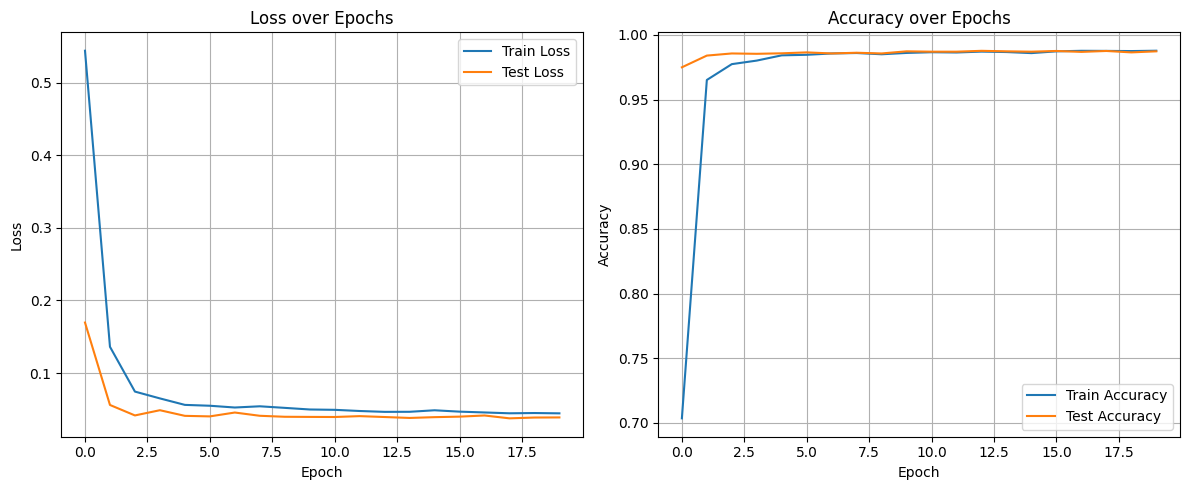


Classification Report:
              precision    recall  f1-score   support

     Class 0       0.99      0.98      0.99      1648
     Class 1       0.99      0.99      0.99      1989

    accuracy                           0.99      3637
   macro avg       0.99      0.99      0.99      3637
weighted avg       0.99      0.99      0.99      3637



In [84]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

# Updated model with dropout
class Model(nn.Module):
    def __init__(self, input_size=X.shape[1], hidden_sizes=[64, 32, 16], output_size=1, dropout_rate=0.3):
        super(Model, self).__init__()
        layers = []
        layers.append(nn.Linear(input_size, hidden_sizes[0]))
        layers.append(nn.ReLU())
        layers.append(nn.Dropout(dropout_rate))  # Add dropout after first layer

        for i in range(len(hidden_sizes)-1):
            layers.append(nn.Linear(hidden_sizes[i], hidden_sizes[i+1]))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_rate))  # Add dropout after each hidden layer

        layers.append(nn.Linear(hidden_sizes[-1], output_size))
        layers.append(nn.Sigmoid())
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

# Initialize model, criterion, and optimizer with weight decay
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Model(dropout_rate=0.3).to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5)  # Add weight decay

# Training loop with early stopping
total_loss_train_plot = []
total_loss_test_plot = []
total_acc_train_plot = []
total_acc_test_plot = []

best_test_loss = float('inf')
patience = 5  # Number of epochs to wait before early stopping
patience_counter = 0
epochs = 20

for epoch in range(epochs):
    total_loss_train = 0
    total_loss_test = 0
    total_acc_train = 0
    total_acc_test = 0

    # Training phase
    model.train()
    for data in train_loader:
        inputs, labels = data
        prediction = model(inputs)
        loss = criterion(prediction, labels.unsqueeze(1))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss_train += loss.item()
        prediction = (prediction > 0.5).float()
        batch_acc = (prediction == labels.unsqueeze(1)).float().mean()
        total_acc_train += batch_acc.item()

    # Testing phase
    model.eval()
    with torch.no_grad():
        for data in test_loader:
            inputs, labels = data
            prediction = model(inputs)
            loss = criterion(prediction, labels.unsqueeze(1))

            total_loss_test += loss.item()
            prediction = (prediction > 0.5).float()
            batch_acc = (prediction == labels.unsqueeze(1)).float().mean()
            total_acc_test += batch_acc.item()

    # Calculate averages
    avg_loss_train = total_loss_train / len(train_loader)
    avg_loss_test = total_loss_test / len(test_loader)
    avg_acc_train = total_acc_train / len(train_loader)
    avg_acc_test = total_acc_test / len(test_loader)

    total_loss_train_plot.append(avg_loss_train)
    total_loss_test_plot.append(avg_loss_test)
    total_acc_train_plot.append(avg_acc_train)
    total_acc_test_plot.append(avg_acc_test)

    print(f"Epoch {epoch+1}/{epochs}:")
    print(f"Train Loss: {avg_loss_train:.4f}, Train Acc: {avg_acc_train:.4f}")
    print(f"Test Loss: {avg_loss_test:.4f}, Test Acc: {avg_acc_test:.4f}")
    print("-" * 50)

    # Early stopping
    if avg_loss_test < best_test_loss:
        best_test_loss = avg_loss_test
        patience_counter = 0
        # Optionally save the best model
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

# Plotting the results
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(total_loss_train_plot, label='Train Loss')
plt.plot(total_loss_test_plot, label='Test Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(total_acc_train_plot, label='Train Accuracy')
plt.plot(total_acc_test_plot, label='Test Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Predictions on test set
model.eval()
all_predictions = []
all_labels = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        preds = model(inputs)
        binary_preds = (preds > 0.5).float()
        all_predictions.extend(binary_preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Print some metrics
from sklearn.metrics import classification_report
print("\nClassification Report:")
print(classification_report(all_labels, all_predictions, target_names=['Class 0', 'Class 1']))

In [85]:

# Making predictions
model.eval()  # Set model to evaluation mode
with torch.no_grad():
    # Get predictions for test set
    test_inputs = next(iter(test_loader))[0]  # Get first batch of test data as example
    test_inputs = test_inputs.to(device)
    predictions = model(test_inputs)

    # Convert to binary predictions
    binary_predictions = (predictions > 0.5).float()

    # Move to CPU and convert to numpy for easier handling
    predictions = predictions.cpu().numpy()
    binary_predictions = binary_predictions.cpu().numpy()

    # Print some example predictions
    print("\nExample Predictions (first 10 samples):")
    for i in range(min(10, len(predictions))):
        print(f"Sample {i+1}: Probability: {predictions[i][0]:.4f}, "
              f"Predicted Class: {binary_predictions[i][0]}")


Example Predictions (first 10 samples):
Sample 1: Probability: 0.9991, Predicted Class: 1.0
Sample 2: Probability: 0.9992, Predicted Class: 1.0
Sample 3: Probability: 0.9986, Predicted Class: 1.0
Sample 4: Probability: 1.0000, Predicted Class: 1.0
Sample 5: Probability: 0.0000, Predicted Class: 0.0
Sample 6: Probability: 0.0001, Predicted Class: 0.0
Sample 7: Probability: 0.0000, Predicted Class: 0.0
Sample 8: Probability: 1.0000, Predicted Class: 1.0
